In [1]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from datetime import datetime
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from data_loader import get_data_loader
from metrics_utility import MetricsCalculator
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2 as cv

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# train, val, test = get_data_loader("/workspaces/hw3_B11023038/ETT-v3/Fold1", shuffle=False, batch_size=32, num_workers=0, preprocess_fn = get_preprocessing_fn(en, ew))
train, val, test = get_data_loader("/workspaces/hw3_B11023038/ETT-v3/Fold1", shuffle=False, batch_size=16, num_workers=4, preprocess_fn = lambda x: x/255.0)

In [5]:
en = "resnet50"
ew = "imagenet"
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
EPOCHS = 50
best_vloss = 1_000_000.

# model_path = './best_weights/model_{}_{}'.format(timestamp, epoch_number)
# model_path = './best_weights/best_model_{}_{}_FocalLoss_OneCycleLR'.format(en, ew)
model_path = './best_weights/best_model_{}_{}_DiceLoss_OneCycleLR'.format(en, ew)

# loss_fn = smp.losses.DiceLoss(mode='binary')
loss_fn = smp.losses.FocalLoss(mode='binary')

In [ ]:
model = smp.UnetPlusPlus(
    encoder_name=en,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=ew,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,          # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,              # model output channels (number of classes in your dataset)
    # activation='sigmoid',   # activation for output layer
)
model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = OneCycleLR(optimizer, max_lr=1e-5,
                       pct_start=0.3,
                       steps_per_epoch=len(train),
                       epochs=EPOCHS,
                       anneal_strategy='linear',
                       cycle_momentum=False)

In [ ]:
def compute_iou(y_pred, y_true):
   tp, fp, fn, tn =  smp.metrics.get_stats(y_pred, y_true, mode='binary', threshold=0.5, num_classes=1)
   iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
   return iou_score

def train_one_epoch():
    running_loss = 0.
    running_iou = 0.

    for i, (inputs, labels) in enumerate(train):
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        running_iou += compute_iou(outputs, labels)
        

    return running_loss / (i+1), running_iou / (i+1)

In [ ]:
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    avg_loss, avg_iou = train_one_epoch()

    running_vloss = 0.0
    running_viou = 0.0
    model.eval()
    with torch.no_grad():
        for i, (vinputs, vlabels) in enumerate(val):
            vinputs = vinputs.to(device, dtype=torch.float)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            viou = compute_iou(voutputs, vlabels)
            running_vloss += vloss
            running_viou += viou

    avg_vloss = running_vloss / (i + 1)
    avg_viou = running_viou / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('IOU train {} valid {}'.format(avg_iou, avg_viou))

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model.save_pretrained(model_path, metrics={'epoch': epoch_number, 'loss': avg_vloss, 'iou': avg_viou}, dataset='ETT-v3')
        # torch.save(model.state_dict(), model_path)

    epoch_number += 1

del model

In [8]:
# Test the model&print the results
test_model = smp.from_pretrained(model_path).to(device)
test_model.eval()
mc = MetricsCalculator(72, 7)

with torch.no_grad():
    running_test_loss = 0.0
    for i, (tinputs, tlabels) in enumerate(test):
        tinputs = tinputs.to(device, dtype=torch.float)
        tlabels = tlabels.to(device)
        toutputs = test_model(tinputs)
        tloss = loss_fn(toutputs, tlabels)
        mc(toutputs, tlabels)
        running_test_loss += tloss
    avg_test_loss = running_test_loss / (i + 1)
metrics = mc.compute()
metrics["loss"] = float(avg_test_loss.cpu())
metrics

Loading weights from local directory


{'iou': 0.7766751786495777,
 'error_cm': 0.7943262411347517,
 'error_0_5cm': 42.5531914893617,
 'error_1cm': 78.72340425531915,
 'loss': 0.04413970559835434}

In [9]:
tinputs = tinputs.cpu().numpy()*255
toutputs = (toutputs.cpu().numpy() > 0.5).astype(np.uint8) * 255
tlabels = tlabels.cpu().numpy().astype(np.uint8) * 255

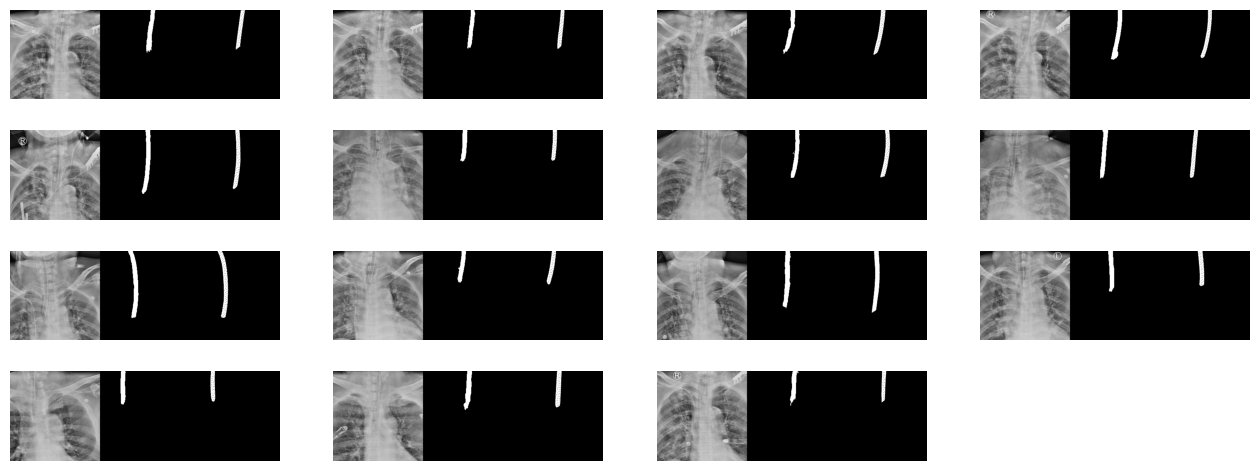

In [10]:
plt.figure(figsize = (16, 6))
for i in range(15):
    plt.subplot(4, 4, i + 1)
    plt.imshow(np.concatenate((tinputs[i][0], toutputs[i][0], tlabels[i][0]), axis=1), cmap='gray')
    plt.axis('off')